# AMME Data Processing

This notebook loads, processes, and epochs the Emory AMME datasets...

---
> Martina Hollearn (martina.hollearn@psych.utah.edu)  
> 05/13/24

## 1. Import Libraries

In [1]:
import os
import mne
import csv
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from scipy.signal import filtfilt, firwin
import matplotlib.pyplot as plt


### Edit these paths for you PC:
Please add your directories as new comments

In [2]:
# For Alireza's PC (Please don't revome the comments)
# rdDir = r'D:\Martina Test\Code'
# wrDir = r'D:\Martina Test\Code'

rdDir = r'D:\Martina Test\Code'
wrDir = r'D:\Martina Test\Code'

rdDir = os.path.normpath(rdDir)
wrDir = os.path.normpath(wrDir)

The Function is not working now

In [ ]:
from mne.filter import notch_filter

def notch_filter_moving_window(data, movingwin,Fs,freqs, tau = 10, mt_bandwidth = 3):

    data = data.T
    N, C  = data.shape 
    Nwin = round(Fs * movingwin[0])  # Number of samples in window
    Nstep = round(movingwin[1] * Fs)  # Number of samples to step through
    Noverlap = Nwin - Nstep  # Number of points in overlap
    p = 0.05/Nwin

    x = np.arange(1, Noverlap + 1)
    smooth = 1. / (1 + np.exp(-tau * (x - Noverlap / 2) / Noverlap))  # Sigmoidal function
    # smooth = np.tile(smooth, (C, 1)).T  # Replicate for each channel

    winstart = np.arange(0, N - Nwin, Nstep)
    nw = len(winstart)  # Number of windows
    datafit = np.zeros((winstart[nw-1]+Nwin, C))


    for chIdx in range(0, C):
        for n in range(0, nw):
            indx = slice(winstart[n], winstart[n] + Nwin)
            datawin = data[indx, chIdx]

            # Apply notch filter to the window
            datafitwin = mne.filter.notch_filter(x = datawin, Fs = Fs, freqs = freqs, 
                                                method='spectrum_fit', mt_bandwidth=mt_bandwidth, 
                                                p_value = p, verbose='WARNING')
            if n==0:
                datafitwin0 = datafitwin.copy()    
            if n > 0:
                # Apply smoothing effect to the overlapping region
                datafitwinTemp = datafitwin.copy()
                datafitwin[:Noverlap] = smooth * datafitwin[:Noverlap] + (1 - smooth) * datafitwin0[Nwin - Noverlap:Nwin]
                datafitwin0 = datafitwinTemp.copy()

            datafit[indx, chIdx] = datafitwin

    return datafit

## 2. Load Data

Check to make sure that the file names for each files called in match. Filenames are inconsistent throughtout the AMME dataset.

In [3]:
subject = 'amyg003'
seeg_filename = f'{subject}_objectMemory_day2_05mA.edf'
file_path = rdDir
event_filename = f'{subject}_LFP_day2_trialtimes.mat'
log_filename = f'{subject}_day2.log'
data_path = os.path.join(file_path, subject, seeg_filename)
events_path = os.path.join(file_path, subject, event_filename)
logfile_path = os.path.join(file_path, subject, log_filename)

# Create Preprocessed data folder
preproc_datapath = os.path.join(file_path,subject,'PreprocessedData', 'Martinas_preprocessing')

if not os.path.exists(preproc_datapath):
    os.makedirs(preproc_datapath)

In [4]:
# Load SEEG data
raw = mne.io.read_raw_edf(data_path, preload=True)

# Get recording info
fs = int(np.round(raw.info['sfreq']))
ch_names = raw.info['ch_names']

# Set all channel types to SEEG
raw.set_channel_types({ch: 'seeg' for ch in ch_names})

# Display info
raw.info

Extracting EDF parameters from D:\Martina Test\Code\amyg003\amyg003_objectMemory_day2_05mA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1637201  =      0.000 ...  1638.164 secs...


<Info | 8 non-empty values
 bads: []
 ch_names: Event, L1d1, L1d3, L1d5, L1d7, L1d9, L3d1, L3d4, L3d7, L5d1, ...
 chs: 129 sEEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 499.7 Hz
 meas_date: 2015-09-10 13:13:13 UTC
 nchan: 129
 projs: []
 sfreq: 999.4 Hz
 subject_info: <subject_info | his_id: Hishida,>
>

In [ ]:
# Test and compare notch filter
# Define your parameters
lowcut = 1  # Lower cutoff frequency
highcut = 119  # Upper cutoff frequency
transition_bandwidth = 1  # Transition bandwidth in Hz

# Dynamically get the subject's sampling rate
samprate = raw.info['sfreq']  # This pulls the sampling rate for the current subject

#Create a Copy and filter the data
proc_data = raw.copy()

data = proc_data.get_data()
data = notch_filter_moving_window(data = data[31:33,:], movingwin=[1.5, .5], Fs=samprate, freqs=[60], tau=10, mt_bandwidth=3)
data = notch_filter_moving_window(data = data.T, movingwin=[2, 1], Fs=samprate, freqs=[42], tau=10, mt_bandwidth=3)

print(data.shape)
savemat(os.path.join(wrDir,'NotchFilterTest.mat'), {'eeg_data': data})

In [ ]:
print(data.shape)
savemat(os.path.join(wrDir,'NotchFilterTest.mat'), {'eeg_data': data})

## 3. Initial Preprocessing steps
- Extract events (trial times, stim types, responses)
- Filtering (lowpass-, highpass-, and notch w harmonics)
- Data cleaning by identifying bad channels and epochs


In [5]:
# Define your parameters
lowcut = 1  # Lower cutoff frequency
highcut = 119  # Upper cutoff frequency
transition_bandwidth = 1  # Transition bandwidth in Hz

# Dynamically get the subject's sampling rate
samprate = raw.info['sfreq']  # This pulls the sampling rate for the current subject

#Create a Copy and filter the data
proc_data = raw.copy()
proc_data.filter(lowcut, highcut, fir_design='firwin', filter_length='auto', phase='zero', fir_window='hamming', 
                 verbose=True,l_trans_bandwidth=1, h_trans_bandwidth=1)

#filter out 42 Hz noise
# proc_data.notch_filter(freqs = [42], picks='seeg', method='spectrum_fit', mt_bandwidth=3,verbose=True)# Joe had this in his code, not sure why it's there
# Apply notch filter (60, 120, 180 Hz)
# proc_data.notch_filter(freqs = [60], picks='seeg', method='spectrum_fit', mt_bandwidth=3,verbose=True)

proc_data.notch_filter(freqs = [42], picks='seeg')# Joe had this in his code, not sure why it's there
proc_data.notch_filter(freqs = [60], picks='seeg')

savemat(os.path.join(wrDir,'PythonPreprocessed.mat'), {'eeg_data': proc_data.get_data()})

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 119.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 119.50 Hz)
- Filter length: 3299 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.5s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 41 - 43 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 41.40
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 41.15 Hz)
- Upper passband edge: 42.60 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 42.85 Hz)
- Filter length: 6597 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6597 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    4.1s


## Visualize Plot Filter vs Raw data to ensure that the filtering works
### accoding to Joe it works fine

In [6]:
# Access the filtered data
filtered_data = proc_data.get_data(picks='seeg')

# Check if there are any NaN values in the data
nan_count = np.isnan(filtered_data).sum()
print(f"Number of NaN values: {nan_count}")

# Check if there are any Inf values in the data
inf_count = np.isinf(filtered_data).sum()
print(f"Number of Inf values: {inf_count}")

Number of NaN values: 0
Number of Inf values: 0


In [7]:
# Function to replace NaN or Inf values with 0
def clean_data(data):
    return np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

# Clean the data for raw, bandpass, and bandpass + notch
raw_data_clean = clean_data(raw.get_data())
bandpass_data_clean = clean_data(bandpass.get_data())
bandpass_and_notch_data_clean = clean_data(proc_data.get_data())


NameError: name 'bandpass' is not defined

In [8]:
### Adjust here
time_start = 0  # in ms
time_end = 200  # in ms
###

# Convert time from ms to sample indices
time_start_idx = int(np.round(time_start * fs / 1000))  # Start sample index
time_end_idx = int(np.round(time_end * fs / 1000))      # End sample index
print(f'Time range: {time_start_idx} to {time_end_idx} samples')

# Clean the data to avoid NaN or Inf values
raw_data_clean = clean_data(raw.get_data())
bandpass_data_clean = clean_data(bandpass.get_data())
bandpass_and_notch_data_clean = clean_data(proc_data.get_data())

# Set up saving path
raw_vs_filter_path = os.path.join(preproc_datapath, 'raw_vs_filter_plots', f'{time_start}ms_to_{time_end}ms')
os.makedirs(raw_vs_filter_path, exist_ok=True)

num_channels = raw_data_clean.shape[0]
time_range = np.arange(time_start_idx, time_end_idx)  # X-axis for ms

# Time range in samples for X-axis
time_range = np.arange(time_start_idx, time_end_idx)

for channel in range(num_channels):
    plt.figure(figsize=(10, 5))

    # Plot raw, bandpass, and bandpass + notch filtered data
    plt.plot(time_range, raw_data_clean[channel, time_start_idx:time_end_idx], label='Raw')
    plt.plot(time_range, bandpass_data_clean[channel, time_start_idx:time_end_idx], label='Bandpass')
    plt.plot(time_range, bandpass_and_notch_data_clean[channel, time_start_idx:time_end_idx], label='Bandpass + Notch')

    # Adding labels and title
    plt.title(f'{subject} Channel {channel + 1} ({raw.ch_names[channel]}) from {time_start}ms to {time_end}ms')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (µV)')

    plt.legend()
    plt.grid(True)

    # Adjust y-axis limits dynamically based on the cleaned data
    y_min = min(np.min(raw_data_clean[channel, time_start_idx:time_end_idx]),
                np.min(bandpass_data_clean[channel, time_start_idx:time_end_idx]),
                np.min(bandpass_and_notch_data_clean[channel, time_start_idx:time_end_idx]))
    y_max = max(np.max(raw_data_clean[channel, time_start_idx:time_end_idx]),
                np.max(bandpass_data_clean[channel, time_start_idx:time_end_idx]),
                np.max(bandpass_and_notch_data_clean[channel, time_start_idx:time_end_idx]))

    if np.isfinite(y_min) and np.isfinite(y_max):
        plt.ylim([y_min - abs(y_min * 0.1), y_max + abs(y_max * 0.1)])  # Add 10% margin
    else:
        plt.ylim([-100, 100])  # Fallback y-axis limit

    # Save the figure
    plt.savefig(os.path.join(raw_vs_filter_path, f'channel_{channel + 1}.png'))
    plt.close()


Time range: 0 to 200 samples


NameError: name 'bandpass' is not defined

In [ ]:
### Adjust here
time_start = 0 # in ms
time_end = 100 # in ms
###

# Convert time from ms to sample indices
time_start_idx = int(np.round(time_start * fs / 1000))  # Start sample index
time_end_idx = int(np.round(time_end * fs / 1000))      # End sample index
print(f'Time range: {time_start_idx} to {time_end_idx} samples')

raw_data = raw.get_data()
bandpass_data = bandpass.get_data()
bandpass_and_notch_data = proc_data.get_data()

# Set up saving path
raw_vs_filter_path = os.path.join(preproc_datapath, 'raw_vs_filter_plots', f'{time_start}ms_to_{time_end}ms')
os.makedirs(raw_vs_filter_path, exist_ok=True)

num_channels = raw_data.shape[0]
time_range = np.arange(time_start_idx, time_end_idx)  # X-axis for ms


for channel in range(num_channels):
    plt.figure(figsize=(10, 5))
    plt.plot(time_range, raw_data[channel, time_start_idx:time_end_idx], label='Raw')
    plt.plot(time_range, bandpass_data[channel, time_start_idx:time_end_idx], label='Bandpass')
    plt.plot(time_range, bandpass_and_notch_data[channel, time_start_idx:time_end_idx], label='Bandpass + Notch')

    # Adding labels and title
    plt.title(f'{subject} Channel {channel + 1} ({raw.ch_names[channel]}) from {time_start}ms to {time_end}ms')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (uV)')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(raw_vs_filter_path, f'channel_{channel + 1}.png'))
    #plt.show()
    plt.close()


### Clean the data visually

1. Mark in the interactive plot all bad channels, then remove them
2. Mark in the interactive plot all bad epochs by annotations, then remove them

### If available, load in dropped channels from DroppedChans.csv

Using matplotlib as 2D backend.


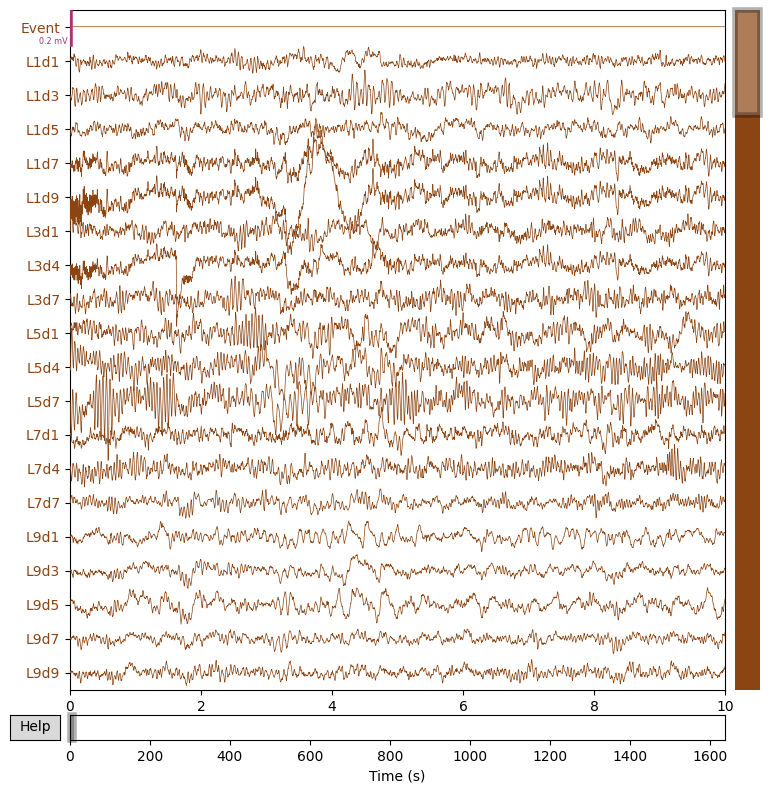

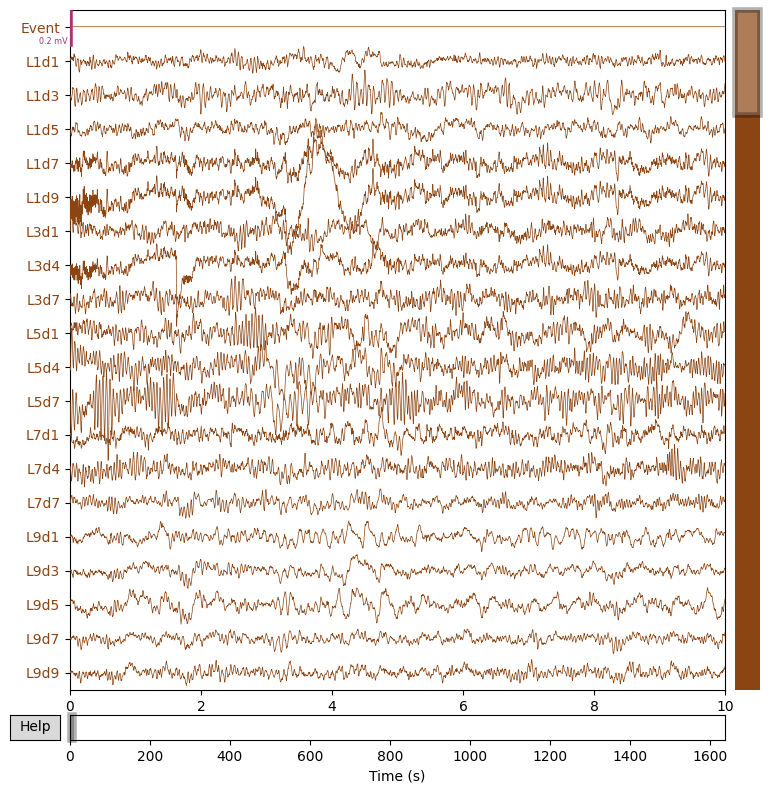

In [9]:
# Plot filtered data with event markers colored by event types
proc_data.plot(title='Filtered EEG Data', block=True, clipping = None)

In [ ]:
# Call in previously dropped channels
file_path = os.path.join(preproc_datapath,'DroppedChans.csv')
dropped_chans = []

with open(file_path, "r") as file:
    reader = csv.reader(file)
    for row in reader:
        dropped_chans.append(row[1])
       
dropped_chans = dropped_chans[1:]
dropped_chans = list(filter(None, dropped_chans))  # Remove empty strings

print(dropped_chans)

In [ ]:
# Drop channels (hand-picked or from previous analysis)
bads =['Event', 'L25d9', 'LSPs7', 'C128', 'C127', 'C126', 'C125', 'C123', 'C124', 'C122', 'C121', 'C120', 'C119', 'L17d1', 'L17d7', 'L13d5'] 

proc_data = proc_data.drop_channels(bads)
proc_data.info

## 4. Post Cleaning Preprocessing Steps
- Re-referencing (e.g., common median reference)
- Downsampling
- Epoching

In [10]:
# Re-referencing
proc_data_ref = proc_data.get_data()  # Convert to numpy array
median_lfp = np.median(proc_data_ref, axis=0)  # Calculate median LFP
proc_data_ref = proc_data_ref - median_lfp  # Subtract median LFP for re-referencing
proc_data = mne.io.RawArray(proc_data_ref, proc_data.info)  # Convert back to MNE object

# Downsampling
fs = 500
proc_data = proc_data.resample(sfreq=fs)

# Plot filtered data with event markers colored by event types
#proc_data.plot(title='Filtered EEG Data', block=True, clipping=None)

Creating RawArray with float64 data, n_channels=129, n_times=1637202
    Range : 0 ... 1637201 =      0.000 ...  1638.164 secs
Ready.


### Load in the log file and filter by stimulation types to find new images

In [11]:
#Load logfile
logfile = pd.read_csv(logfile_path, delimiter='\t', skiprows=2, skipfooter=1) #tab delimited csv file is our log file format, reject first 2 rows and the last row

# Filter out the NaN or New response condition rows
#enumerate stim categories from log files to numbers
#ORIGINAL
logfile.loc[logfile['CONDITION'] == 'nostim', 'CONDITION'] = 0
logfile.loc[logfile['CONDITION'] == 'stim', 'CONDITION'] = 1
logfile.loc[logfile['CONDITION'] == 'new', 'CONDITION'] = 9
logfile.loc[logfile['CONDITION'] == 'None', 'CONDITION'] = np.nan

# Identify NaN rows
dropped_nan_indices = logfile[logfile['CONDITION'].isna()].index
print(f'Indices of NaN rows: {dropped_nan_indices.tolist()}')

# Drop NaN rows and reorder the index
logfile = logfile.dropna(subset=['CONDITION']).reset_index(drop=True)

# Save CONDITION column to a .npy file
np.save(os.path.join(preproc_datapath, subject + '_stimcondition'), logfile['CONDITION'].values)
np.save(os.path.join(preproc_datapath, subject + '_dropped_nan_indices'), dropped_nan_indices)#save dropped nan indices

# Test loading the saved file
test = np.load(os.path.join(preproc_datapath, subject + '_stimcondition.npy'), allow_pickle=True)
print('length of stim condition',len(test))

Indices of NaN rows: []
length of stim condition 120


C:\Users\alire\AppData\Local\Temp\ipykernel_3220\435193284.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  logfile = pd.read_csv(logfile_path, delimiter='\t', skiprows=2, skipfooter=1) #tab delimited csv file is our log file format, reject first 2 rows and the last row


### From the same log file find response types and perform Signal Detection analysis

In [12]:
# Extract responses from log file for remembered vs forgotten analysis
logfile.loc[logfile['YES/NO'] == 'yes', 'YES/NO'] = 1 # 1 for yes
logfile.loc[logfile['YES/NO'] == 'no', 'YES/NO'] = 0 # 0 for no

# Ensure no NaN values in YES/NO column
logfile['YES/NO'] = pd.to_numeric(logfile['YES/NO'], errors='coerce')
logfile = logfile.dropna(subset=['YES/NO']).reset_index(drop=True)
logfile['YES/NO'] = logfile['YES/NO'].astype(int) #convert to integer

# Calculate remembered vs forgotten data from responses: from 'Condition' column we can extract image condition as 'new' and anything that's not 'new' as 'target'
hit = logfile[(logfile['CONDITION']!=9) & (logfile['YES/NO'] == 1)]
miss = logfile[(logfile['CONDITION']!=9) & (logfile['YES/NO'] == 0)]
fa= logfile[(logfile['CONDITION'] ==9) & (logfile['YES/NO'] == 1)] 
cr = logfile[(logfile['CONDITION'] ==9) & (logfile['YES/NO'] == 0)]

print('hit:', hit.shape)
print('miss:', miss.shape)
print('fa:', fa.shape)
print('cr:', cr.shape)

nhits = hit.shape[0]
nmiss = miss.shape[0]
nfa= fa.shape[0] # -----> check this with a new subject bc we got 40/40 FA/CR for amyg030
ncr = cr.shape[0]

remembered = hit # where the subject responded YES,and accurately recognized the image
forgotten = miss # where the subject responded NO, and did NOT accurately recognize the image

n_remembered = remembered.shape[0]
n_forgotten = forgotten.shape[0]

hitrate = nhits/(nhits+nmiss)
hits_index = hit.index
miss_index = miss.index
cr_index = cr.index
fa_index = fa.index

print("remembered: ", n_remembered)
print("forgotten: ", n_forgotten)
print("fa:", nfa)
print("cr:", ncr)

hit: (9, 7)
miss: (71, 7)
fa: (0, 7)
cr: (40, 7)
remembered:  9
forgotten:  71
fa: 0
cr: 40


### Save Signal Detection data info

In [ ]:
# Create a dataframe to store the indices and their corresponding response types
response_data = pd.DataFrame({
    'Index': hit.index.tolist() + miss.index.tolist() + fa.index.tolist() + cr.index.tolist(),
    'Response': ['hit'] * len(hit.index) + ['miss'] * len(miss.index) + ['fa'] * len(fa.index) + ['cr'] * len(cr.index)
})

# Sort the dataframe by the index to maintain the order of the original logfile
response_data = response_data.sort_values(by='Index').reset_index(drop=True)

# Save the dataframe to a CSV file
response_data.to_csv(os.path.join(preproc_datapath, subject + '_SignalDetection_ResponseData.csv'))

#Write signal detection ratios into a txt file
with open(os.path.join(preproc_datapath, subject + '_SignalDetection_Ratios_Before_Dropping_Epochs.txt'), 'w') as f:
    f.write(f'Hits: {nhits}\n')
    f.write(f'Misses: {nmiss}\n')
    f.write(f'False Alarms: {nfa}\n')
    f.write(f'Correct Rejections: {ncr}\n')
    f.write(f'Hit Rate: {hitrate}\n')
    f.write(f'Total Trials: {nhits + nmiss + nfa + ncr}\n')
    f.write(f'Remembered: {n_remembered}\n')
    f.write(f'Forgotten: {n_forgotten}\n')
    f.write(f'Hit Rate: {hitrate}\n')

### After filtering the logfile, drop rows to keep only remembered and forgotten items (no new items)

In [13]:
# Keep track of the original indices before dropping rows
original_indices = logfile.index.to_list()
print("Original length of rows:",len(original_indices))

#Drop rows where condition is 'new', so we can analyze remembered vs forgotten
logfile = logfile[logfile['CONDITION']!=9].reset_index(drop=True)
print("New number of rows:", logfile.shape[0])
print(logfile['YES/NO'])

Original length of rows: 120
New number of rows: 80
0     0
1     0
2     0
3     0
4     0
     ..
75    0
76    0
77    0
78    0
79    0
Name: YES/NO, Length: 80, dtype: int64


### Load in trial times from matlab file, filter by response types for remembered and forgotten images (filter out new images)

In [22]:
datapath = r'D:\Martina Test\Code\amyg003'
subject = 'amyg003'
event_filename = f'{subject}_LFP_day2_trialtimes.mat'
events_path = os.path.join(datapath, event_filename)
print(events_path)

events = loadmat(events_path, simplify_cells=True)
day2_trial_times = events['day2_trial_times']
day2_trial_times = day2_trial_times * fs # convert to samples
day2_trial_times = np.array([int(np.round(x)) for x in day2_trial_times]) # round to nearest integer
print('lenght of day2_trial_times:',len(day2_trial_times))
print("length of dropped nan indices:",len(dropped_nan_indices))
print(dropped_nan_indices.shape)   

# Determine the indices to drop in day2_trial_times
indices_to_drop = list(fa.index) + list(cr.index)
print("Number of rows to drop:",len(indices_to_drop))

# Drop the corresponding trial times
day2_trial_times = np.delete(day2_trial_times, indices_to_drop)
print("Length of FA trials:", len(fa.index), "FA indices:", fa.index)
print("Length of CR trials:", len(cr.index),"CR indices:", cr.index)

# Verify the indices match between day2_trial_times and logfile
assert len(day2_trial_times) == logfile.shape[0], "Mismatch between day2_trial_times and logfile"

# Now, day2_trial_times should match the filtered logfile indices
print("Indices match successfully!")
print("Remaining length of day2_trial_times:", len(day2_trial_times))

D:\Martina Test\Code\amyg003\amyg003_LFP_day2_trialtimes.mat
lenght of day2_trial_times: 120
length of dropped nan indices: 0
(0,)
Number of rows to drop: 40
Length of FA trials: 0 FA indices: Index([], dtype='int64')
Length of CR trials: 40 CR indices: Index([  1,   6,  10,  11,  12,  17,  18,  21,  25,  28,  29,  32,  35,  39,
        43,  46,  49,  51,  52,  57,  58,  61,  66,  71,  74,  78,  82,  86,
        88,  93,  98,  99, 100, 101, 103, 106, 111, 112, 116, 119],
      dtype='int64')
Indices match successfully!
Remaining length of day2_trial_times: 80


In [23]:
# Create event array based on response types (remembered vs forgotten)
n_events = len(day2_trial_times)
(print(n_events))
events_array = np.zeros((n_events, 3), dtype=int)
print(events_array.shape)
events_array[:, 0] = day2_trial_times
print(logfile['YES/NO'].values)
print(len(logfile['YES/NO'].values))

# Count the number of zeros
zero_count = np.count_nonzero(logfile['YES/NO'].values ==0)
print("Number of zeros:", zero_count)
events_array[:, 2] = logfile['YES/NO'].values # set event IDs here based on log file info

#Check if events_array[3] is the same as logfile['YES/NO']
if events_array[:, 2].all() == logfile['YES/NO'].values.all():
    print("Event IDs match successfully!")
else:
    print("Event IDs do not match!")

80
(80, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0]
80
Number of zeros: 71
Event IDs match successfully!


### Epoch data based on response types with events marking remembered (1) versus forgotten (0) items

Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 5001 original time points ...
0 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using data from preloaded Raw for 20 events and 5001 original time points ...


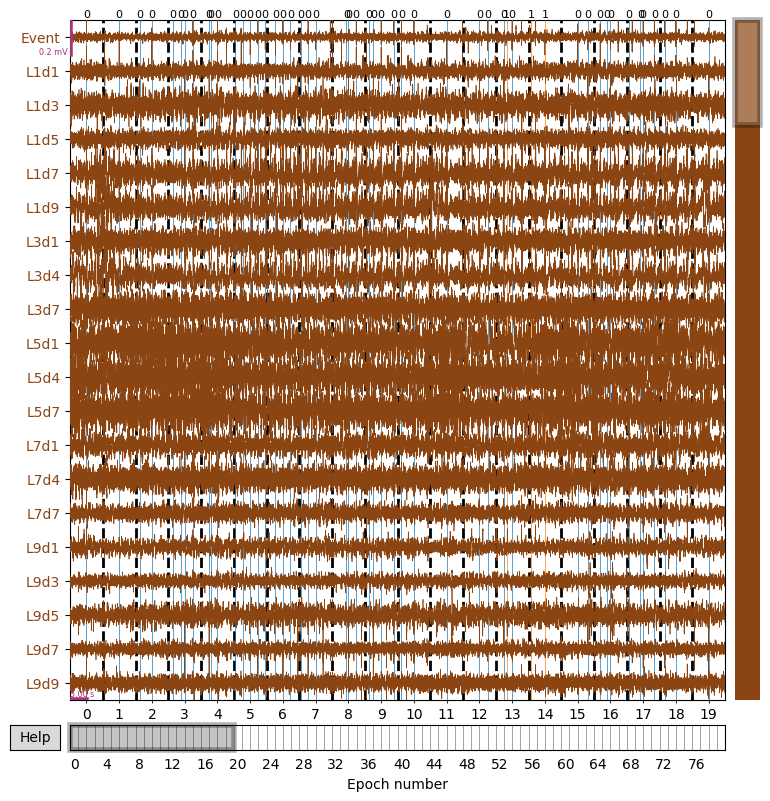

num events 80
num epochs 80


In [24]:
# Epoching
epochs = mne.Epochs(proc_data, events_array, tmin = -5, tmax = 5, baseline = None, reject=None) # 5s before to 5s after event onset
epochs.plot(title='Epoched EEG Data', block=True, events=events_array)

# savemat(os.path.join(wrDir,'PythonPreprocessed.mat'), {'eeg_data': proc_data.get_data()})
print('num events',events_array.shape[0])
print('num epochs',len(epochs))

# Drop epochs if needed which will also drop that trial
# epochs.info['bads']

In [ ]:
savemat(os.path.join(wrDir,'PythonPreprocessed.mat'), {'eeg_data': proc_data.get_data()})

## 5. Export the data into numpy arrays for analysis

In [ ]:
# Get raw data, list of rejected epochs, list of bad_chans
epoch_data = epochs.get_data()
drop_epochs = [n for n, dl in enumerate(epochs.drop_log) if len(dl)]
events_mask = np.ones(events_array.shape[0], dtype = bool)
events_mask[drop_epochs] = False #drop epochs from events array
keep_events = events_array[events_mask] 

# Export dropped epochs, dropped chans, events, and channel labels to .csv files
np.save(os.path.join(preproc_datapath, ('PreprocessedData')), epoch_data)
np.save(os.path.join(preproc_datapath, ('Events')), keep_events) #saves only the epochs that were not dropped manually
pd.DataFrame(drop_epochs, columns = ['Dropped Epochs']).to_csv(os.path.join(preproc_datapath,'DroppedEpochs.csv'))
pd.DataFrame(bads, columns = ['Dropped Chans']).to_csv(os.path.join(preproc_datapath,'DroppedChans.csv'))
pd.DataFrame(epochs.ch_names, columns = ['Chan']).to_csv(os.path.join(preproc_datapath,'ChanLabels.csv'))

In [ ]:
a = np.load(os.path.join(preproc_datapath, ('Events.npy')))